# define target variable

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('occupation_mapped.csv')

print(data.info())
print(data.isnull().sum())

# Create a binary column, 1 for "Successful", 0 for any other status
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    3212 non-null   int64  
 1   DCP_activation_date                   3212 non-null   object 
 2   DCP_start_date                        3212 non-null   object 
 3   DCP_start_date_year                   3212 non-null   int64  
 4   DCP_start_date_month                  3212 non-null   int64  
 5   date between activate and start       3212 non-null   int64  
 6   duration_of_dcp                       3212 non-null   int64  
 7   DCP_drop_date                         3212 non-null   object 
 8   DCP_drop_status                       3212 non-null   object 
 9   gender_at_activation                  3212 non-null   object 
 10  marital_status_at_activation          3175 non-null   object 
 11  age_at_activation

# Call LLM to categorize occupation_at_activation

In [45]:

data['occupation_at_activation'] = data['occupation_at_activation'].fillna('Unemployed')
occupations = data['occupation_at_activation']



In [ ]:
import requests
import json


def get_llm_categories_via_openrouter(occupations, api_key, timeout=30):
    """
    Send occupations to OpenRouter's LLM API to get high-level categories in JSON format.
    """
    # Format the prompt
    prompt = f"""
    Group the following occupations into logical categories. Every occupation in the list must be categorized without exception, even if the categorization is not 100% accurate. Do not omit, deduplicate, or summarize any entry. 

    Return the output in **strict JSON format**, where the keys are the category names, and the values are lists of occupations. Do not include explanations, comments, or representative examples—categorize every occupation explicitly.

    Example format:
    {{
        "Healthcare": ["Nurse", "Doctor"],
        "Transportation": ["Truck Driver", "Delivery Driver"],
        "Education": ["Teacher", "Professor"],
        "Unemployed": ["Unemployed", "None"]
    }}

    Here are the occupations:
    {occupations}
    """

    # Define headers and payload
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "anthropic/claude-3.5-sonnet:beta",  # Replace with the desired model
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0
    }

    # Send the API request
    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        json=payload,
        timeout=timeout,
        
    )
    response.raise_for_status()  # Raise exception for HTTP errors
    response_data = response.json()
    return response_data.get('choices', [{}])[0].get('message', {}).get('content', "")

def process_in_batches(occupations, batch_size, api_key):
    """
    Process occupations in batches to avoid context window limits and categorize all occupations.
    """
    # Split occupations into batches
    def split_into_batches(data, size):
        for i in range(0, len(data), size):
            yield data[i:i + size]
    
    all_categories = {}
    
    for batch in split_into_batches(occupations, batch_size):
        # Format the batch for LLM processing
        formatted_occupations = "\n".join(f"- {occupation}" for occupation in batch)
        
        # Call the LLM for categorization
        llm_response = get_llm_categories_via_openrouter(formatted_occupations, api_key)
        
        # Extract JSON from response
        try:
            categories_dict = json.loads(llm_response)
        except json.JSONDecodeError:
            print(f"Invalid JSON response for batch: {llm_response}")
            continue
        
        # Merge results into all_categories
        for category, batch_occupations in categories_dict.items():
            all_categories.setdefault(category, []).extend(batch_occupations)
    
    return all_categories


# Save the response to a variable
api_key = "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"  # Replace with your actual OpenRouter API key
batch_size = 100  # Adjust based on the LLM's token/context limit

categories = process_in_batches(occupations, batch_size, api_key)


In [57]:
# Step 1: Create Reverse Mapping from `categories`
def create_reverse_mapping(categories):
    """
    Create a reverse mapping of occupation to category from the categories dictionary.
    """
    reverse_mapping = {}
    for category, occupations in categories.items():
        for occupation in occupations:
            reverse_mapping[occupation.strip()] = category
    return reverse_mapping

occupation_to_category = create_reverse_mapping(categories)

# Step 2: Map Categories to the DataFrame
def map_occupations_to_categories(data, reverse_mapping):
    """
    Map occupations in the DataFrame to categories based on reverse mapping.
    """
    data['occupation_category'] = data['occupation_at_activation'].map(reverse_mapping).fillna('Unmapped')
    return data

# Apply the mapping
data = map_occupations_to_categories(data, occupation_to_category)

# Step 3: Check the Result
print(data[['occupation_at_activation', 'occupation_category']])

     occupation_at_activation           occupation_category
0      truck driver (on WSIB)                Transportation
1                    DR PATAL                    Healthcare
2                 Housekeeper        Miscellaneous Services
3           PACKING ASSISTANT     Warehouse & Manufacturing
4                         PSW       Healthcare and Wellness
...                       ...                           ...
3207                   DRIVER  Transportation and Logistics
3208               Unemployed       Unemployment/Disability
3209                     Crew            Labor/General Work
3210           General Helper            Labor/General Work
3211             BOILER MAKER                 Manufacturing

[3212 rows x 2 columns]


In [91]:
# Save the DataFrame to a CSV file
data.to_csv('occupation_mapped.csv', index=False)

# EBM


Model Performance:
ROC AUC: 0.7418909592822637

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       391
           1       0.67      0.46      0.54       252

    accuracy                           0.70       643
   macro avg       0.69      0.66      0.66       643
weighted avg       0.69      0.70      0.68       643



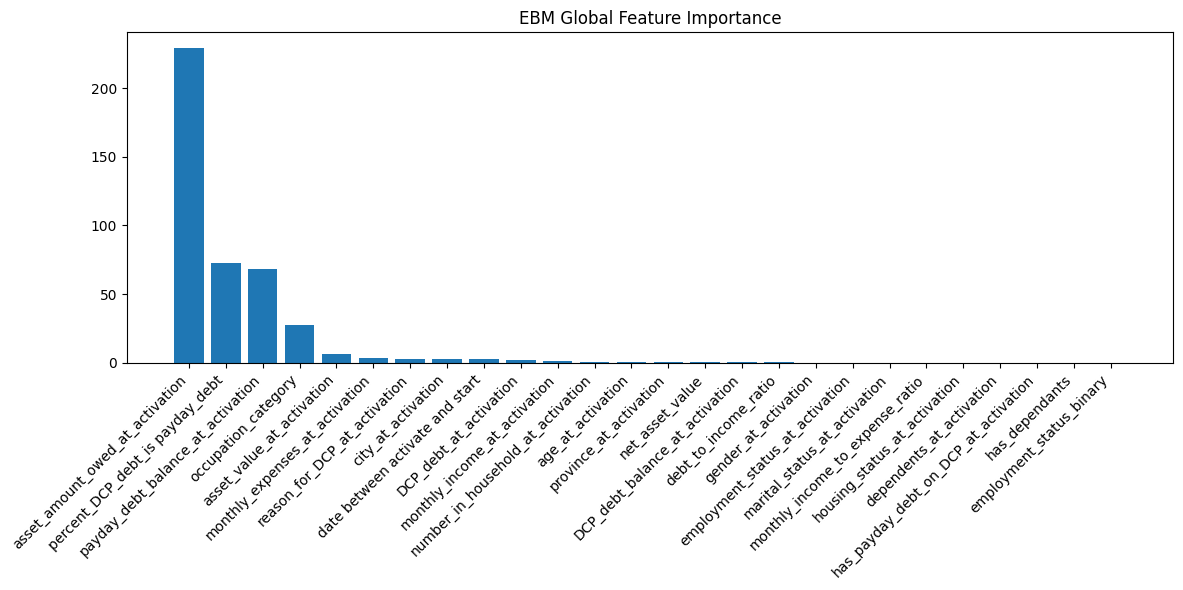

In [31]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Create binary employment status feature
data['employment_status_binary'] = (data['employment_status_at_activation'] != 'unemployed').astype(int)

def preprocess_data(data):
    """Enhanced preprocessing for EBM compatibility"""
    df_processed = data.copy()
    
    # 1. Drop unnecessary columns and leakage columns
    columns_to_drop = [
        'id', 'DCP_drop_status',
        'DCP_activation_date', 'DCP_start_date', 'DCP_drop_date',
        'DCP_start_date_year', 'DCP_start_date_month',
        'postal_prefix_at_activation',
        'duration_of_dcp',
        'occupation_at_activation'
    ]
    columns_to_drop.extend([col for col in df_processed.columns if col.startswith('pmtstatus')])
    
    df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
    
    # 2. Separate features and target
    X = df_processed.drop('target', axis=1)
    y = df_processed['target']
    
    # 3. Define column types
    categorical_cols = [
        'gender_at_activation',
        'marital_status_at_activation',
        'housing_status_at_activation',
        'employment_status_at_activation',
        'reason_for_DCP_at_activation',
        'occupation_category',
        'city_at_activation',
        'province_at_activation'
    ]
    
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # 4. Handle missing values
    for col in numerical_cols:
        X[col] = X[col].fillna(X[col].median())
    
    for col in categorical_cols:
        X[col] = X[col].fillna('Unknown')
        # Convert to string for EBM compatibility
        X[col] = X[col].astype(str)
    
    # 5. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 6. Scale numerical features
    '''
    scaler = StandardScaler()
    X_train_numerical = scaler.fit_transform(X_train[numerical_cols])
    X_test_numerical = scaler.transform(X_test[numerical_cols])
    '''
    # Convert back to dataframe
    # X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_cols, index=X_train.index)
    # X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_cols, index=X_test.index)
    
    # Replace numerical columns with scaled versions
    X_train = X_train.copy()
    X_test = X_test.copy()
    # X_train[numerical_cols] = X_train_numerical
    # X_test[numerical_cols] = X_test_numerical
    
    return X_train, X_test, y_train, y_test, numerical_cols, categorical_cols

# Apply preprocessing
X_train, X_test, y_train, y_test, numerical_cols, categorical_cols = preprocess_data(data)

from interpret.glassbox import ExplainableBoostingClassifier

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Initialize and train EBM
ebm = ExplainableBoostingClassifier(
    n_jobs=-1,
    interactions=10,
    max_rounds=500,
    min_samples_leaf=10,
    max_leaves=5,
    learning_rate=0.01,
    validation_size=0.15,
    early_stopping_rounds=50,
    random_state=42
)

# Fit the model
ebm.fit(X_train, y_train)

# Make predictions
y_pred = ebm.predict(X_test)
y_pred_proba = ebm.predict_proba(X_test)[:, 1]

# Print model performance
print("\nModel Performance:")
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get feature importance scores
feature_importance = []
for i, feature_name in enumerate(X_train.columns):
    score = abs(ebm.term_scores_[i].sum())
    feature_importance.append((feature_name, score))

# Sort features by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)
feature_names, importance_values = zip(*feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_names)), importance_values)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.title('EBM Global Feature Importance')
plt.tight_layout()
plt.show()

# Save feature importance to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
})


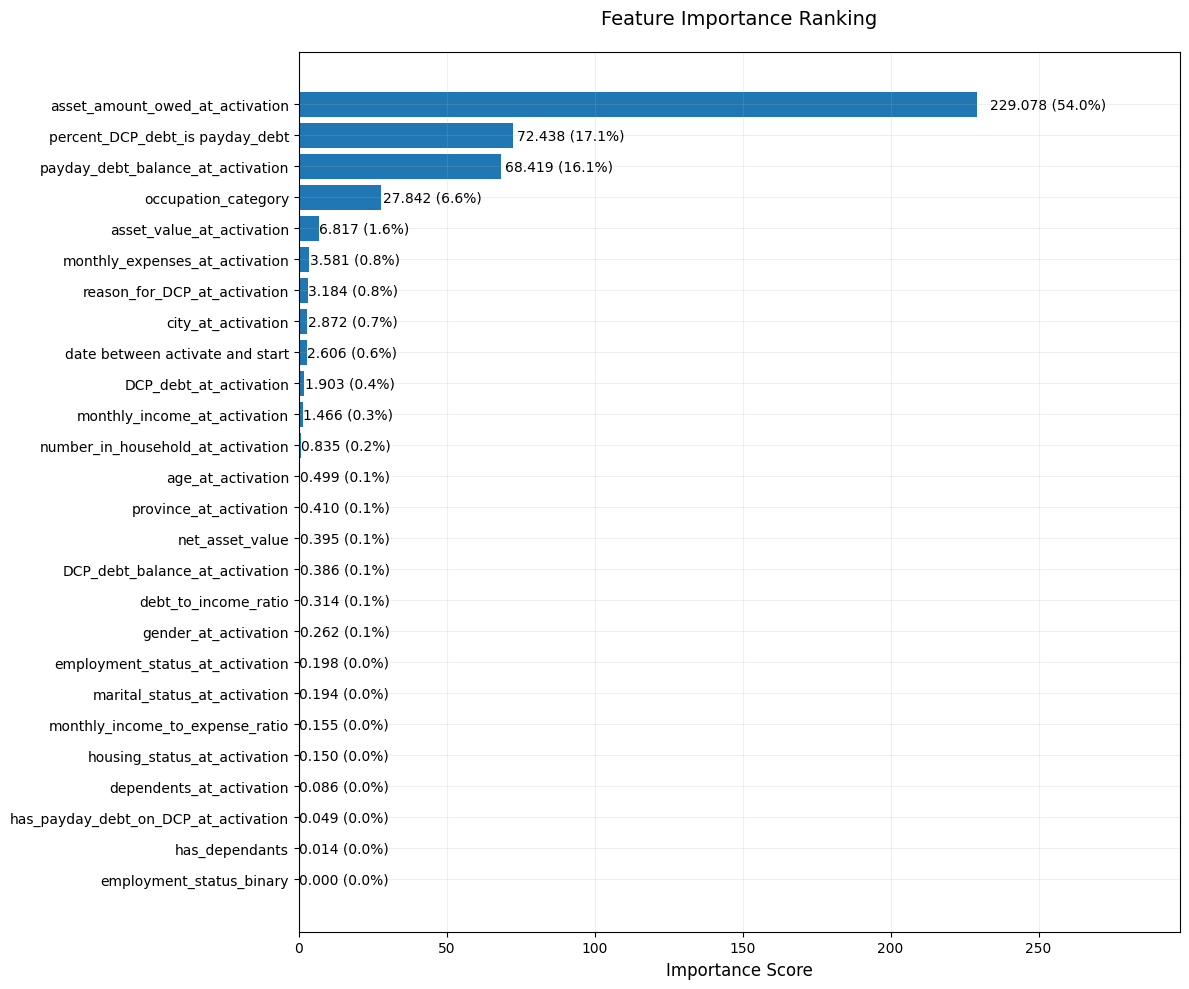

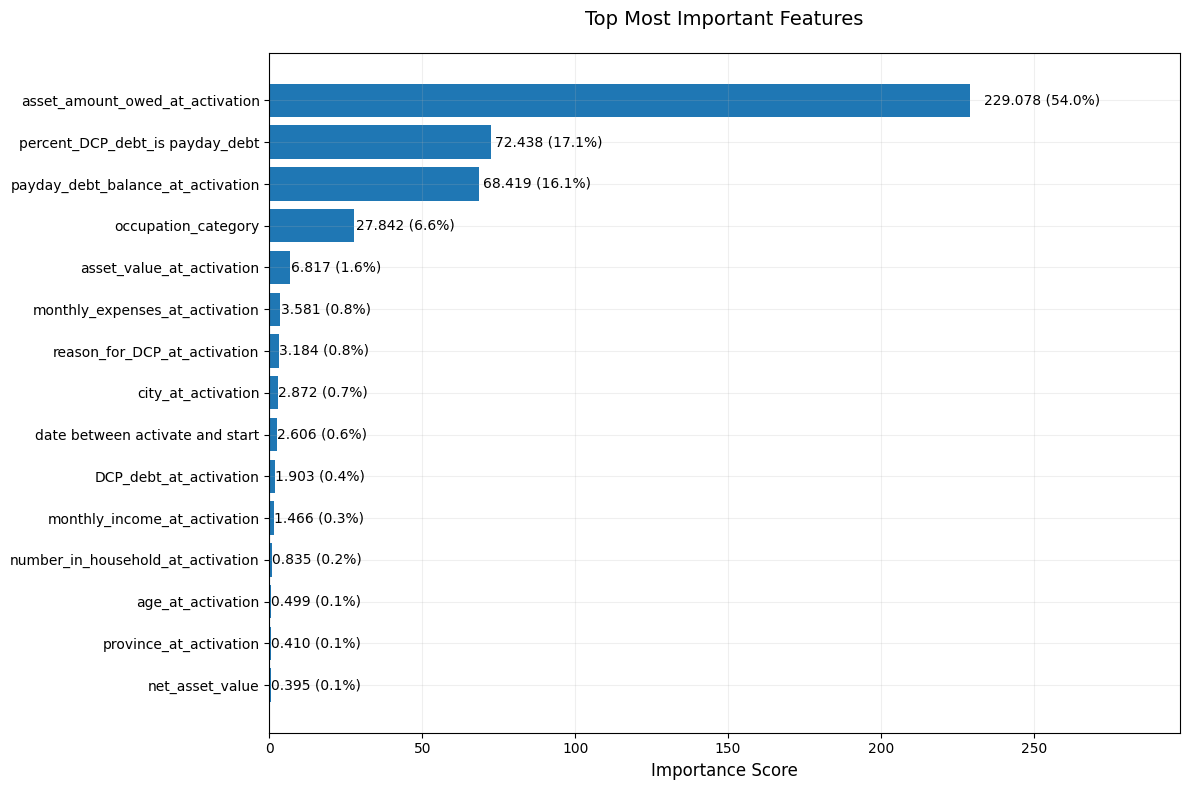

In [3]:
# Sort features by importance in descending order
sorted_indices = np.argsort(importance_values)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = [importance_values[i] for i in sorted_indices]

# Create a horizontal bar plot with most important features at the top
plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_features)), sorted_importance)
# Reverse the y-axis to put most important at top
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_features)), sorted_features)
plt.title('Feature Importance Ranking', fontsize=14, pad=20)
plt.xlabel('Importance Score', fontsize=12)

# Add value labels to the right of each bar
total_importance = sum(sorted_importance)
for i, v in enumerate(sorted_importance):
    percentage = (v / total_importance) * 100
    plt.text(v * 1.02, i, f'{v:.3f} ({percentage:.1f}%)', va='center')

plt.grid(True, alpha=0.2)
# Extend x-axis limit to ensure all labels are visible
plt.xlim(0, max(sorted_importance) * 1.3)

plt.tight_layout()
plt.show()

# Create version focusing on top 15 features
top_n = min(15, len(sorted_features))
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), sorted_importance[:top_n])
# Reverse the y-axis to put most important at top
plt.gca().invert_yaxis()
plt.yticks(range(top_n), sorted_features[:top_n])
plt.title('Top Most Important Features', fontsize=14, pad=20)
plt.xlabel('Importance Score', fontsize=12)

# Add value labels to the right of each bar
for i, v in enumerate(sorted_importance[:top_n]):
    percentage = (v / total_importance) * 100
    plt.text(v * 1.02, i, f'{v:.3f} ({percentage:.1f}%)', va='center')

plt.grid(True, alpha=0.2)
# Extend x-axis limit to ensure all labels are visible
plt.xlim(0, max(sorted_importance[:top_n]) * 1.3)

plt.tight_layout()
plt.show()


Top 5 features: ['asset_amount_owed_at_activation', 'percent_DCP_debt_is payday_debt', 'payday_debt_balance_at_activation', 'occupation_category', 'asset_value_at_activation']
Feature name mapping: {'asset_amount_owed_at_activation': 'Asset Amount Owed At Activation', 'percent_DCP_debt_is payday_debt': 'Percent Dcp Debt Is Payday Debt', 'payday_debt_balance_at_activation': 'Payday Debt Balance At Activation', 'occupation_category': 'Occupation Category', 'asset_value_at_activation': 'Asset Value At Activation'}


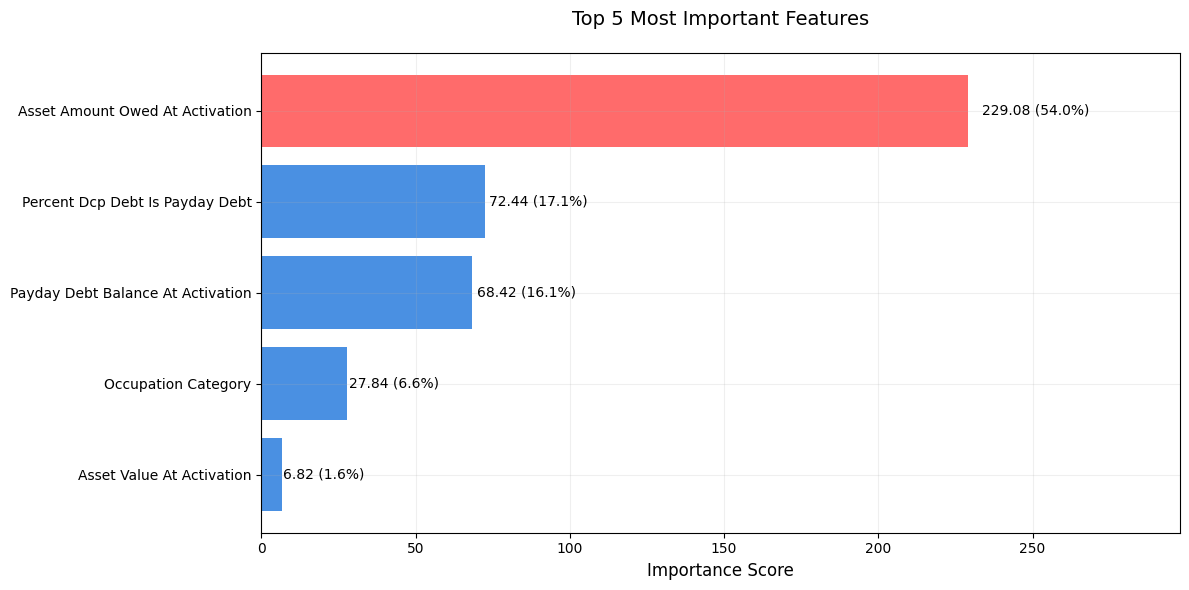

In [35]:
# Extract top 5 features and their importance values
top_5_features = sorted_features[:5]
top_5_importance = sorted_importance[:5]

# Print actual feature names to verify
print("Top 5 features:", top_5_features)

# Create a mapping of feature names to more natural names
feature_name_mapping = {}  # Start with empty mapping

# Add mappings for features we see in top 5
for feature in top_5_features:
    # Default to capitalized version with spaces
    natural_name = feature.replace('_', ' ').title()
    feature_name_mapping[feature] = natural_name

print("Feature name mapping:", feature_name_mapping)

# Map feature names to natural names
natural_names = [feature_name_mapping.get(f, f) for f in top_5_features]

# Create color palette - main color for bars with accent for top feature
colors = ['#FF6B6B'] + ['#4A90E2'] * 4  # First bar red, rest blue

# Create horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_5_features)), top_5_importance, color=colors)

# Customize appearance
plt.gca().invert_yaxis()  # Most important at top
plt.yticks(range(len(top_5_features)), natural_names)
plt.title('Top 5 Most Important Features', fontsize=14, pad=20)
plt.xlabel('Importance Score', fontsize=12)

# Add value labels to the right of each bar
for i, v in enumerate(top_5_importance):
    percentage = (v / total_importance) * 100
    plt.text(v * 1.02, i, f'{v:.2f} ({percentage:.1f}%)', 
             va='center', fontsize=10)

# Add subtle grid lines
plt.grid(True, alpha=0.2)

# Extend x-axis limit to ensure all labels are visible
plt.xlim(0, max(top_5_importance) * 1.3)

# Adjust layout and display
plt.tight_layout()
plt.show()


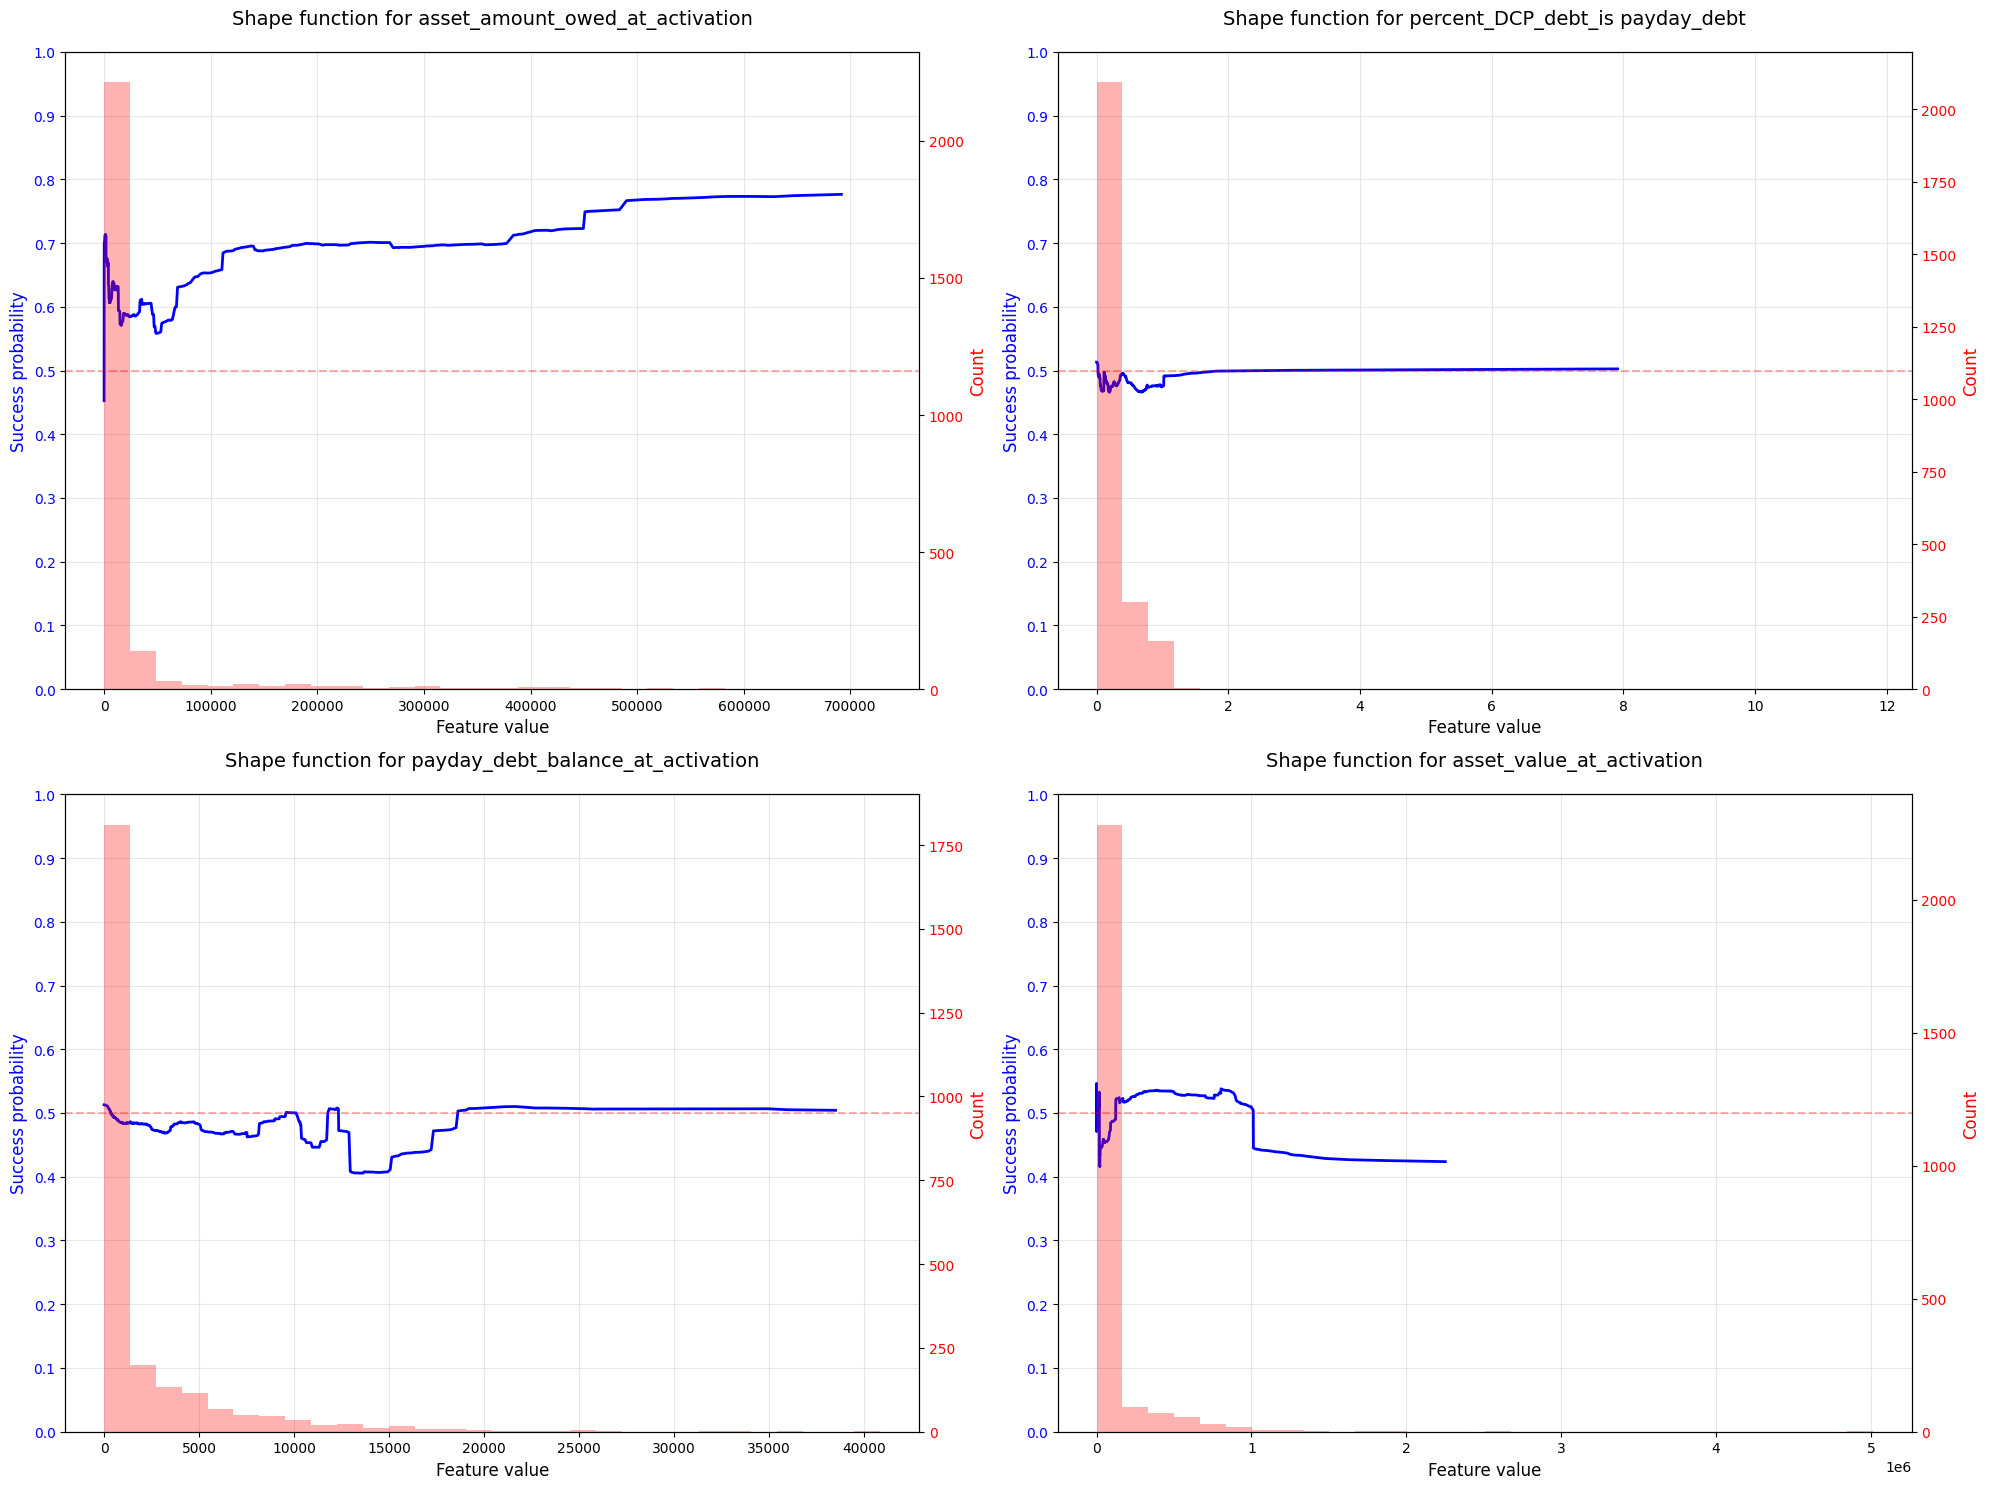


Feature Importance Scores for Top 5 Features:
asset_amount_owed_at_activation: 229.0783
percent_DCP_debt_is payday_debt: 72.4384
payday_debt_balance_at_activation: 68.4194
occupation_category: 27.8421
asset_value_at_activation: 6.8175


In [32]:
import seaborn as sns
# Get global explanation
ebm_global = ebm.explain_global()

# Create a figure with subplots for top 5 features
plt.figure(figsize=(20, 15))

plot_count = 0
for i, feature in enumerate(top_5_features):
    # Skip occupation_category 
    if X_train[feature].dtype == 'object':
        continue
        
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    
    # Get shape function data for this feature
    feature_idx = ebm_global.feature_names.index(feature)
    shape_values = ebm_global.data(feature_idx)
    
    # Extract x and y values, handling potential missing 'names' key
    x_values = shape_values.get('names', range(len(shape_values['scores'])))
    y_values = shape_values['scores']
    
    # Ensure x_values and y_values have same length
    min_len = min(len(x_values), len(y_values))
    x_values = x_values[:min_len]
    y_values = y_values[:min_len]
    
    # Convert scores to probabilities using logistic function
    y_values = 1 / (1 + np.exp(-np.array(y_values)))
    
    # Create twin axes for distribution plot
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot the shape function on primary axis
    ax1.plot(x_values, y_values, 'b-', linewidth=2)
    
    # Add confidence intervals if available
    if 'errors' in shape_values:
        errors = shape_values['errors'][:min_len]  # Trim errors to match
        # Convert confidence intervals to probability scale
        lower_bound = 1 / (1 + np.exp(-(np.array(y_values) - np.array(errors))))
        upper_bound = 1 / (1 + np.exp(-(np.array(y_values) + np.array(errors))))
        ax1.fill_between(
            x_values,
            lower_bound,
            upper_bound,
            alpha=0.2,
            color='blue'
        )
    
    # Plot feature distribution as histogram on secondary axis
    ax2.hist(X_train[feature], bins=30, color='red', alpha=0.3)
    
    # Customize the plot
    ax1.set_title(f"Shape function for {feature}", fontsize=14, pad=20)
    ax1.set_xlabel("Feature value", fontsize=12)
    ax1.set_ylabel("Success probability", fontsize=12, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylabel("Count", fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax1.grid(True, alpha=0.3)
    
    # Add 0.5 probability line for reference
    ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
    
    # Set y-axis limits between 0 and 1 for probability with more ticks
    ax1.set_ylim(0, 1)
    ax1.set_yticks(np.arange(0, 1.1, 0.1))  # Add ticks every 0.1
    
    # Rotate x-axis labels if needed
    if isinstance(x_values, (list, np.ndarray)) and len(x_values) > 0:
        plt.xticks(rotation=45 if len(str(x_values[0])) > 10 else 0)

plt.tight_layout()
plt.show()

# Print feature importance scores for reference
print("\nFeature Importance Scores for Top 5 Features:")
for feature in top_5_features:
    feature_idx = ebm_global.feature_names.index(feature)
    importance = abs(ebm.term_scores_[feature_idx].sum())
    print(f"{feature}: {importance:.4f}")

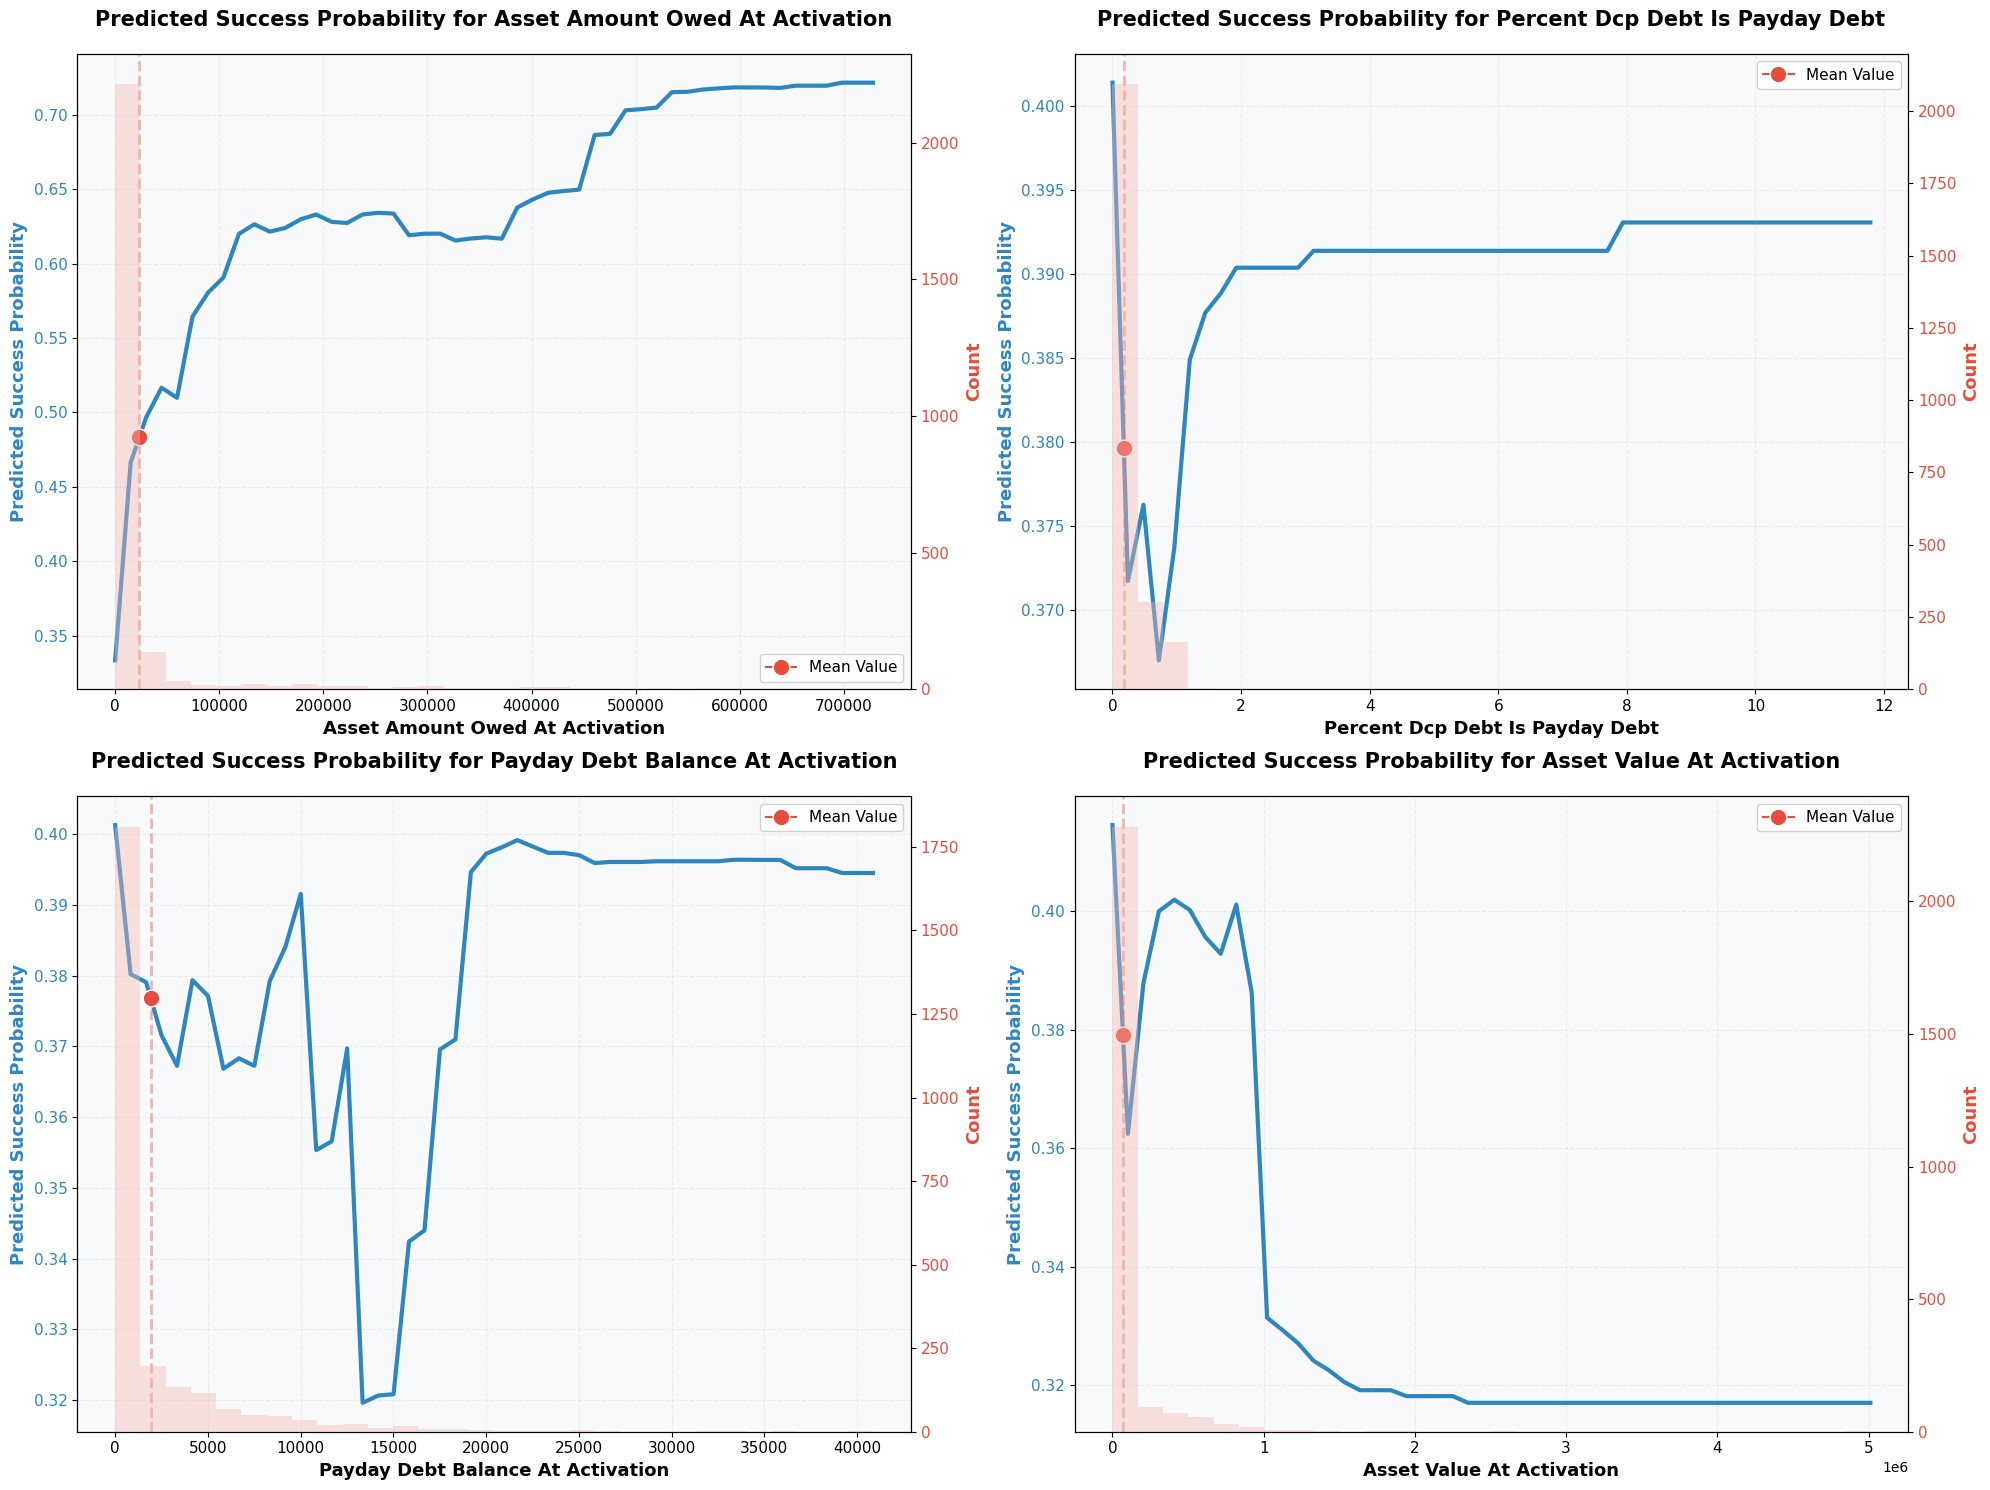

In [36]:
# Create partial dependence plots for top 4 numeric features
from sklearn.inspection import partial_dependence
import numpy as np

plt.figure(figsize=(20, 15))

plot_count = 0
for i, feature in enumerate(top_5_features, 1):
    # Skip occupation_category
    if X_train[feature].dtype == 'object':
        continue
        
    plot_count += 1
    ax1 = plt.subplot(2, 2, plot_count)
    
    # Create second y-axis for distribution
    ax2 = ax1.twinx()
    
    # For numeric features, use linspace
    feature_values = np.linspace(
        X_train[feature].min(),
        X_train[feature].max(),
        num=50
    )
    
    # Create temporary datasets with the feature values
    pdp_values = []
    for val in feature_values:
        X_temp = X_train.copy()
        X_temp[feature] = val
        pred_probs = ebm.predict_proba(X_temp)[:, 1]
        pdp_values.append(pred_probs.mean())
    
    # Plot PDP with thicker line and larger markers
    ax1.plot(feature_values, pdp_values, color='#2E86C1', linewidth=3)
    
    # Plot feature distribution as histogram with a more muted color
    ax2.hist(X_train[feature], bins=30, color='#F5B7B1', alpha=0.4)
    
    # Clean up feature name by removing underscores
    clean_feature_name = feature.replace('_', ' ').title()
    
    ax1.set_xlabel(clean_feature_name, fontsize=13, fontweight='bold')
    ax1.set_ylabel('Predicted Success Probability', fontsize=13, color='#2E86C1', fontweight='bold')
    ax2.set_ylabel('Count', fontsize=13, color='#E74C3C', fontweight='bold')
    ax1.set_title(f'Predicted Success Probability for {clean_feature_name}', 
                  fontsize=15, pad=20, fontweight='bold')
    
    # Add subtle grid and style improvements
    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='#2E86C1', labelsize=11)
    ax2.tick_params(axis='y', labelcolor='#E74C3C', labelsize=11)
    ax1.tick_params(axis='x', labelsize=11)
    
    # Add mean marker with improved styling
    mean_val = X_train[feature].mean()
    pd_at_mean = np.interp(mean_val, feature_values, pdp_values)
    ax1.axvline(mean_val, color='#E74C3C', linestyle='--', alpha=0.4, linewidth=2)
    ax1.plot(mean_val, pd_at_mean, marker='o', color='#E74C3C', 
            markersize=12, label='Mean Value', markeredgecolor='white')
    
    # Add legend with improved styling
    ax1.legend(fontsize=11, framealpha=0.9, loc='best')
    
    # Set background color to very light gray
    ax1.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()


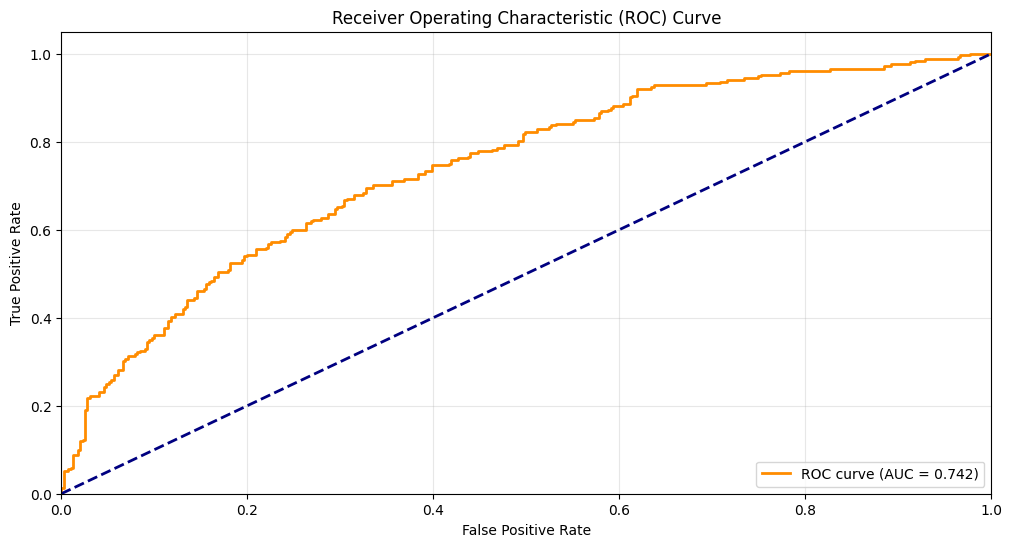

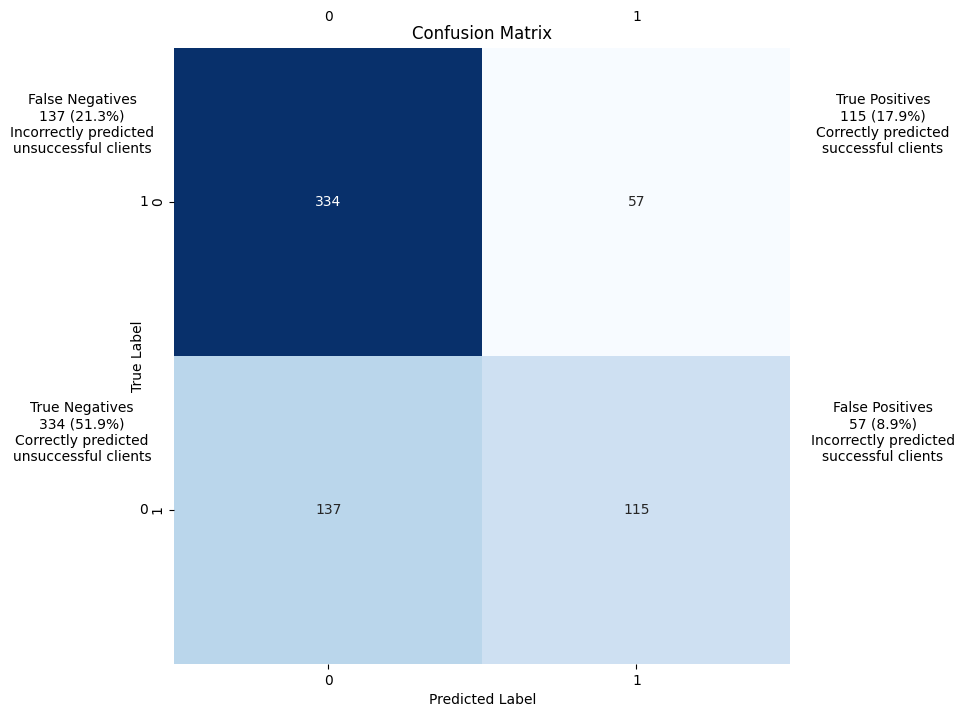

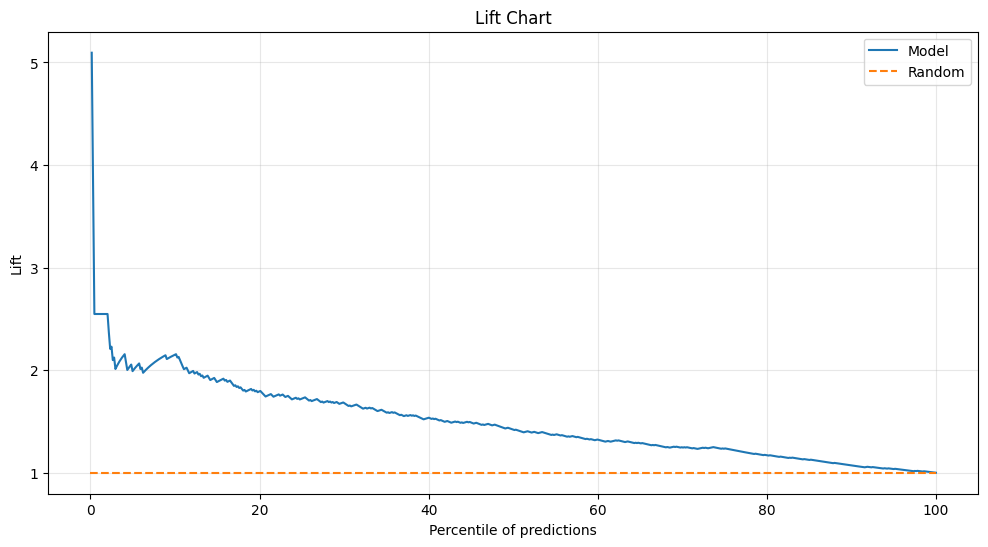


Brier Score: 0.1978


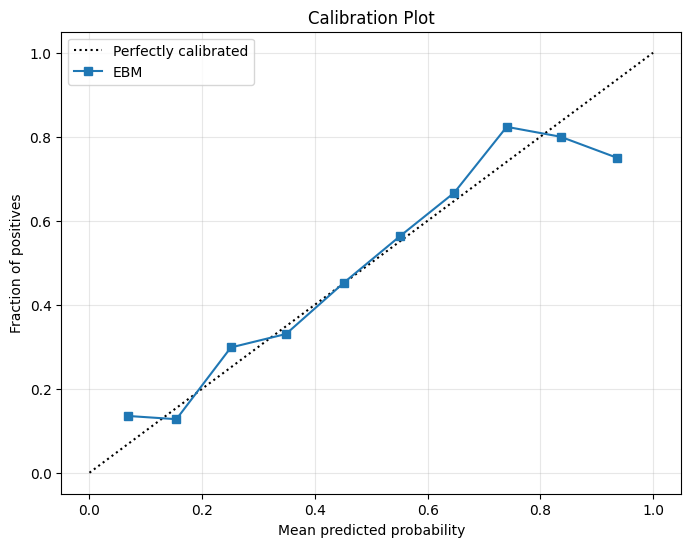

In [41]:
# Plot AUC-ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, test_probabilities)
roc_auc_ebm_1 = auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_ebm:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions using 0.5 threshold
y_pred = (test_probabilities >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Calculate percentages for annotations
total = cm.sum()
percentages = cm / total * 100

# Add business-friendly labels with percentages
plt.text(-0.3, 1.25, f'True Negatives\n{cm[0,0]} ({percentages[0,0]:.1f}%)\nCorrectly predicted\nunsuccessful clients', 
         ha='center', va='center')
plt.text(2.3, 1.25, f'False Positives\n{cm[0,1]} ({percentages[0,1]:.1f}%)\nIncorrectly predicted\nsuccessful clients', 
         ha='center', va='center')
plt.text(-0.3, 0.25, f'False Negatives\n{cm[1,0]} ({percentages[1,0]:.1f}%)\nIncorrectly predicted\nunsuccessful clients', 
         ha='center', va='center')
plt.text(2.3, 0.25, f'True Positives\n{cm[1,1]} ({percentages[1,1]:.1f}%)\nCorrectly predicted\nsuccessful clients', 
         ha='center', va='center')

# Add axis labels
plt.text(-0.1, 1.5, '0', ha='center', va='center')
plt.text(0.5, -0.1, '0', ha='center', va='center')
plt.text(-0.1, 0.5, '1', ha='center', va='center')
plt.text(1.5, -0.1, '1', ha='center', va='center')

plt.show()

# Plot Lift Chart
def plot_lift_chart(y_true, y_prob):
    # Sort by probability in descending order
    df = pd.DataFrame({'prob': y_prob, 'true': y_true})
    df = df.sort_values('prob', ascending=False)
    
    # Calculate cumulative gains
    total_positive = df['true'].sum()
    random_gains = np.linspace(0, total_positive, len(df))
    cumulative_gains = df['true'].cumsum()
    
    # Calculate lift
    lift = cumulative_gains / random_gains
    
    plt.figure(figsize=(12, 6))
    plt.plot(np.linspace(0, 100, len(df)), lift, label='Model')
    plt.plot([0, 100], [1, 1], '--', label='Random')
    plt.xlabel('Percentile of predictions')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_lift_chart(y_test, test_probabilities)

# Calculate and display Brier Score
from sklearn.metrics import brier_score_loss
brier = brier_score_loss(y_test, test_probabilities)
print(f"\nBrier Score: {brier:.4f}")

# Plot Calibration Curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, test_probabilities, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, "s-", label="EBM")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


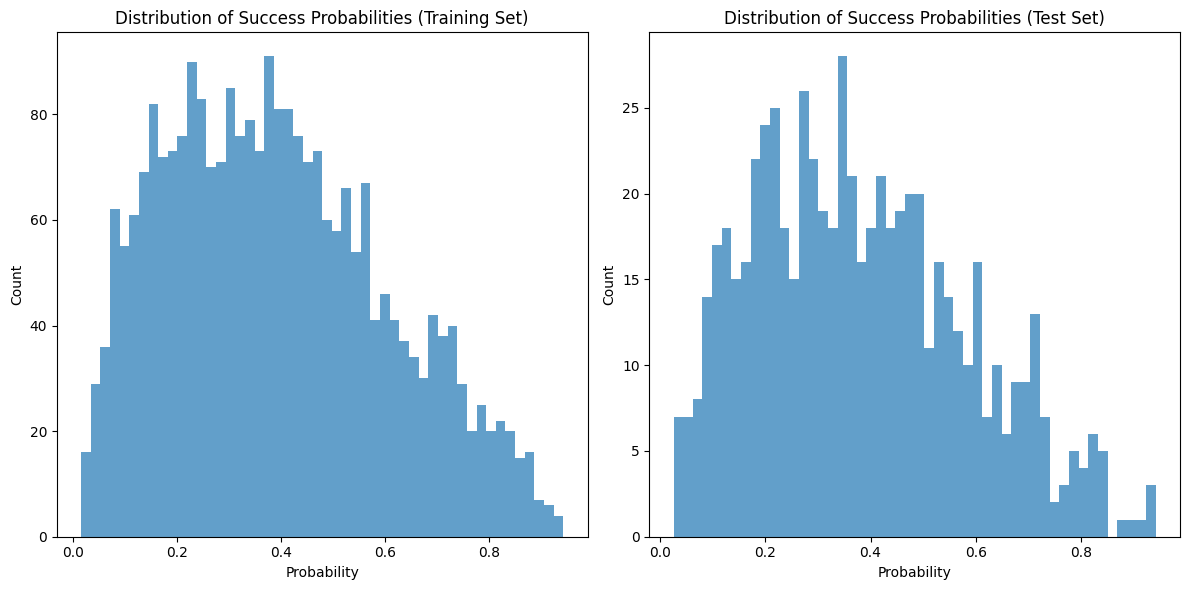

In [14]:
# Get success probability for training data
train_probabilities = ebm.predict_proba(X_train)[:, 1]

# Get success probability for test data 
test_probabilities = ebm.predict_proba(X_test)[:, 1]

# Add probabilities to new columns in original datasets
X_train['ebm_success_probability'] = train_probabilities
X_test['ebm_success_probability'] = test_probabilities

# Plot distribution of probabilities
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_probabilities, bins=50, alpha=0.7)
plt.title('Distribution of Success Probabilities (Training Set)')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(test_probabilities, bins=50, alpha=0.7)
plt.title('Distribution of Success Probabilities (Test Set)')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()




# Logistic Regression

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('occupation_mapped.csv')
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)
def preprocess_data(data):
    # Create a copy
    df_processed = data.copy()
    
    # 1. Drop unnecessary columns
    # 1. Drop unnecessary columns and leakage columns
    columns_to_drop = [
        'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04', 
        'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08', 
        'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
        'id', 'DCP_drop_status',
        'DCP_activation_date', 'DCP_start_date', 'DCP_drop_date',
        'DCP_start_date_year', 'DCP_start_date_month',
        'postal_prefix_at_activation',
        'duration_of_dcp',  # This might also be leakage if it's the total duration
        'occupation_at_activation'
    ]
    
    df_processed = df_processed.drop(columns=columns_to_drop)
    
    # 2. Separate features and target
    X = df_processed.drop('target', axis=1)
    y = df_processed['target']
    
    # 3. Define column types
    onehot_cols = [
        'gender_at_activation',
        'marital_status_at_activation',
        'housing_status_at_activation',
        'employment_status_at_activation',
       # 'city_at_activation',
        'reason_for_DCP_at_activation',
      #  'province_at_activation',
       # 'occupation_at_activation',
       'occupation_category'
    ]
    
    label_cols = [
        'city_at_activation',
        'province_at_activation',
       # 'occupation_at_activation',
    ]

    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # 4. Handle missing values and label encoding for high-cardinality categories
    
    for col in label_cols:
        # Fill missing values first
        X[col] = X[col].fillna('Unknown')
        # Apply label encoding
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # 5. Create preprocessing steps for numerical and one-hot columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # 6. Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, onehot_cols)
        ])
    
    # 7. Fit and transform the data
    X_transformed = preprocessor.fit_transform(X)
    
    # Get feature names
    onehot_features = []
    for i, col in enumerate(onehot_cols):
        categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i][1:]
        onehot_features.extend([f"{col}_{cat}" for cat in categories])
    
    # Combine all feature names
    feature_names = numerical_cols + onehot_features
    
    # 8. Create final transformed dataset
    X_final = np.column_stack([
        X_transformed,
    #    X[label_cols].values
    ])
    
    # 9. Create DataFrame with feature names
    X_transformed_df = pd.DataFrame(X_final, columns=feature_names)
    
    # 10. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_transformed_df, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, feature_names

# Apply preprocessing
X_train, X_test, y_train, y_test, feature_names = preprocess_data(data)

Model Performance:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       391
           1       0.61      0.47      0.53       252

    accuracy                           0.67       643
   macro avg       0.66      0.64      0.64       643
weighted avg       0.67      0.67      0.66       643

ROC-AUC Score: 0.714

Cross-validation ROC-AUC scores: [0.71435156 0.70877761 0.71969408 0.70663557 0.73092869]
Average CV ROC-AUC: 0.716 (+/- 0.017)

Top 15 Most Important Features:
                                               Feature  Coefficient
180   occupation_category_Manufacturing and Industrial     1.537749
125             occupation_category_General Employment    -1.500523
134  occupation_category_Government Benefits/Assist...    -1.300064
280        occupation_category_Unemployment/Disability    -1.288034
194              occupation_category_Military/Veterans     1.241502
202                          occupation_category_Other    -1.22

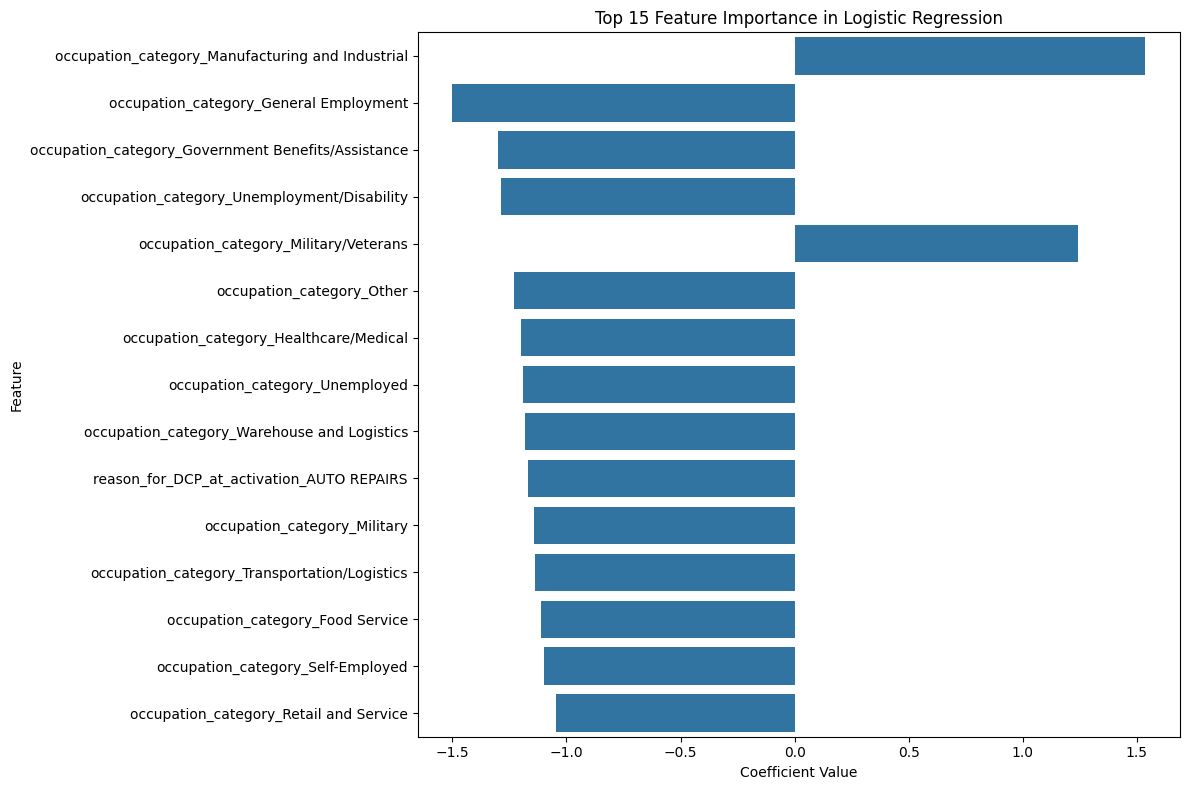

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fit Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# 2. Get model performance
y_pred = lr_model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]):.3f}")

# 3. Cross-validation scores
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
print(f"Average CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# 4. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Print top 15 most important features
print("\nTop 15 Most Important Features:")
print(feature_importance[['Feature', 'Coefficient']].head(15))

# 5. Visualize Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [20]:
# Calculate ROC curve points
from sklearn.metrics import roc_curve

# Calculate ROC curve points and store the data
fpr, tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc_score = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

# Store the ROC curve data in a dictionary
roc_auc_lr = {
    'fpr': fpr,
    'tpr': tpr,
    'auc_score': auc_score
}
# Calculate calibration curve data
from sklearn.calibration import calibration_curve

# Get predicted probabilities
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Store calibration data in dictionary
calibration_lr = {
    'prob_true': prob_true,
    'prob_pred': prob_pred
}


# Catboost

0:	learn: 0.6809878	total: 4.31ms	remaining: 2.15s
100:	learn: 0.4696089	total: 312ms	remaining: 1.23s
200:	learn: 0.3742583	total: 622ms	remaining: 925ms
300:	learn: 0.3040076	total: 979ms	remaining: 647ms
400:	learn: 0.2476307	total: 1.31s	remaining: 325ms
499:	learn: 0.2051278	total: 1.64s	remaining: 0us
Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       376
           1       0.62      0.51      0.56       267

    accuracy                           0.67       643
   macro avg       0.66      0.65      0.65       643
weighted avg       0.66      0.67      0.66       643

ROC-AUC Score: 0.72


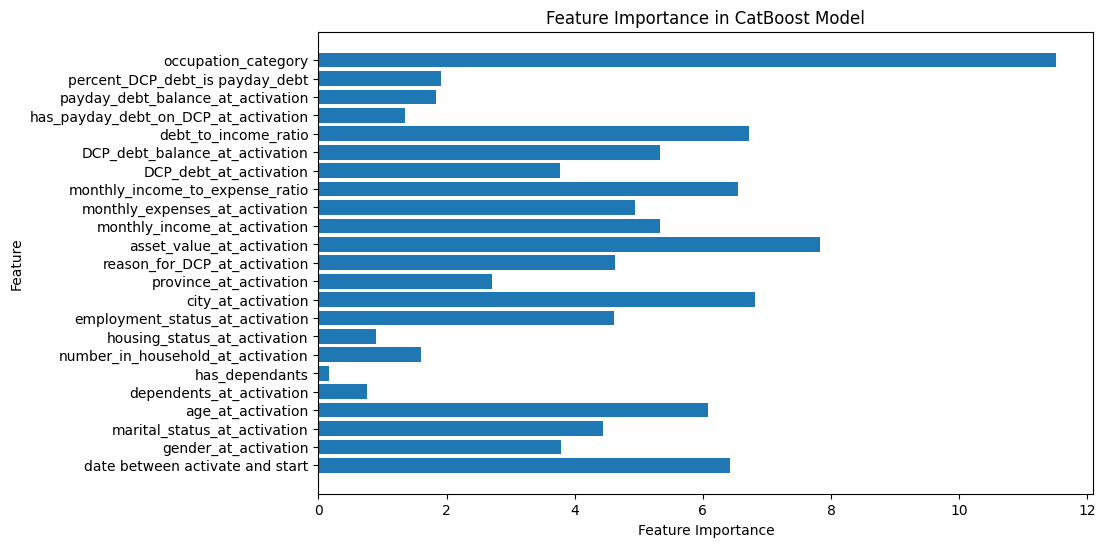

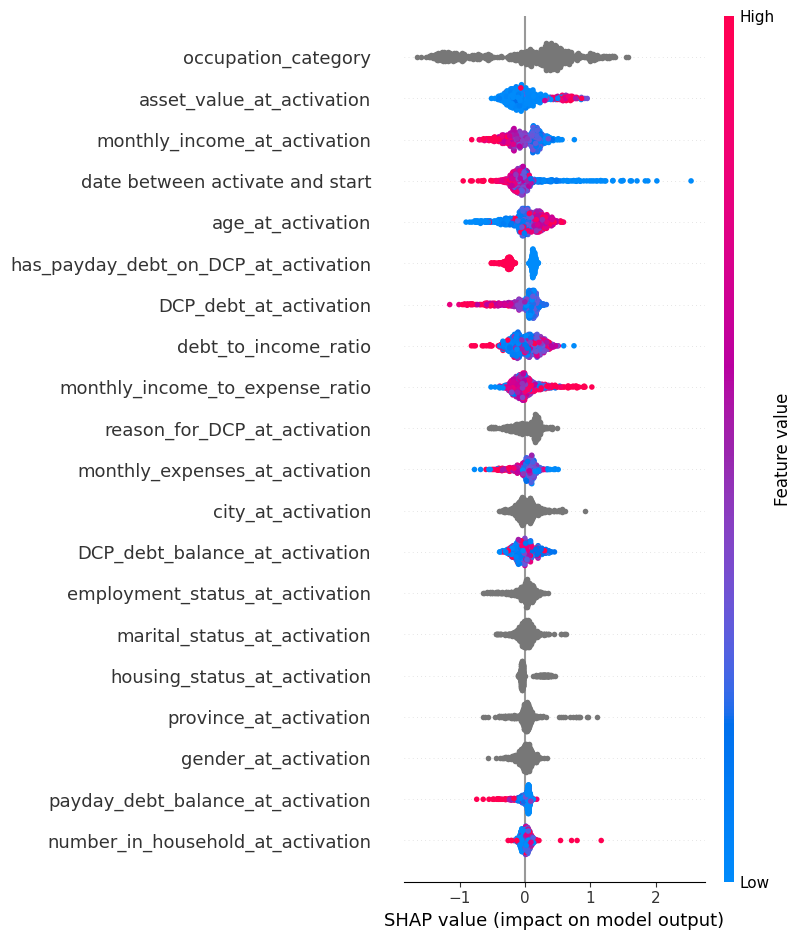

0:	learn: 0.6809878	total: 4.06ms	remaining: 2.03s
100:	learn: 0.4696089	total: 318ms	remaining: 1.25s
200:	learn: 0.3742583	total: 667ms	remaining: 992ms
300:	learn: 0.3040076	total: 993ms	remaining: 656ms
400:	learn: 0.2476307	total: 1.31s	remaining: 324ms
499:	learn: 0.2051278	total: 1.63s	remaining: 0us
Accuracy (using Pool): 0.67


In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap

# Load the dataset
data = pd.read_csv('occupation_mapped.csv')

# Define target label
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

# Drop irrelevant or leakage columns
columns_to_drop = [
    'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04',
    'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08',
    'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
    'id', 'DCP_drop_status', 'DCP_activation_date', 'DCP_start_date',
    'DCP_drop_date', 'DCP_start_date_year', 'DCP_start_date_month',
    'postal_prefix_at_activation', 'asset_amount_owed_at_activation',
    'net_asset_value', 'duration_of_dcp', 'occupation_at_activation'
]
data = data.drop(columns=columns_to_drop)

# Handling Missing Values
# Fill missing numerical features with the median and categorical features with 'Unknown'
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna('Unknown', inplace=True)
    else:
        data[column].fillna(data[column].median(), inplace=True)

# Separate target variable (y) and features (X)
y = data['target']
X = data.drop(['target'], axis=1)  # Drop the target column from features

# Identify categorical and numerical columns
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype != 'object']

# Scale the numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CatBoost Model
catboost_model = CatBoostClassifier(
    iterations=500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate for training
    depth=6,  # Depth of each tree in the model
    cat_features=categorical_features,  # Specify which features are categorical
    verbose=100,  # Verbosity of training
    random_seed=42
)

# Fit the CatBoost Model
catboost_model.fit(X_train, y_train)

# Predict on the Test Set
y_pred = catboost_model.predict(X_test)

# Predict Probabilities for ROC-AUC Score
y_prob = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the Model
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc:.2f}')

# Feature Importance
feature_importances = catboost_model.get_feature_importance()
features = X.columns

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in CatBoost Model')
plt.show()

# SHAP Values for Detailed Interpretation
# Use SHAP to interpret feature importance
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Plot summary of feature importance using SHAP
shap.summary_plot(shap_values, X_test)

# Creating Pool object for CatBoost (Optional - improves efficiency)
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Re-fitting the model using Pool for efficiency
catboost_model.fit(train_pool)

# Predictions using Pool
predictions = catboost_model.predict(test_pool)

# Accuracy using Pool
accuracy_with_pool = accuracy_score(y_test, predictions)
print(f'Accuracy (using Pool): {accuracy_with_pool:.2f}')

# Calculate ROC curve points and store the data
fpr, tpr, _ = roc_curve(y_test, catboost_model.predict_proba(X_test)[:, 1])
auc_score = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])

# Store the ROC curve data in a dictionary
roc_auc_cb = {
    'fpr': fpr,
    'tpr': tpr,
    'auc_score': auc_score
}

# Calculate calibration curve data
from sklearn.calibration import calibration_curve

# Get predicted probabilities
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Store calibration data in dictionary
calibration_cb = {
    'prob_true': prob_true,
    'prob_pred': prob_pred
}


# Model performence comparison 

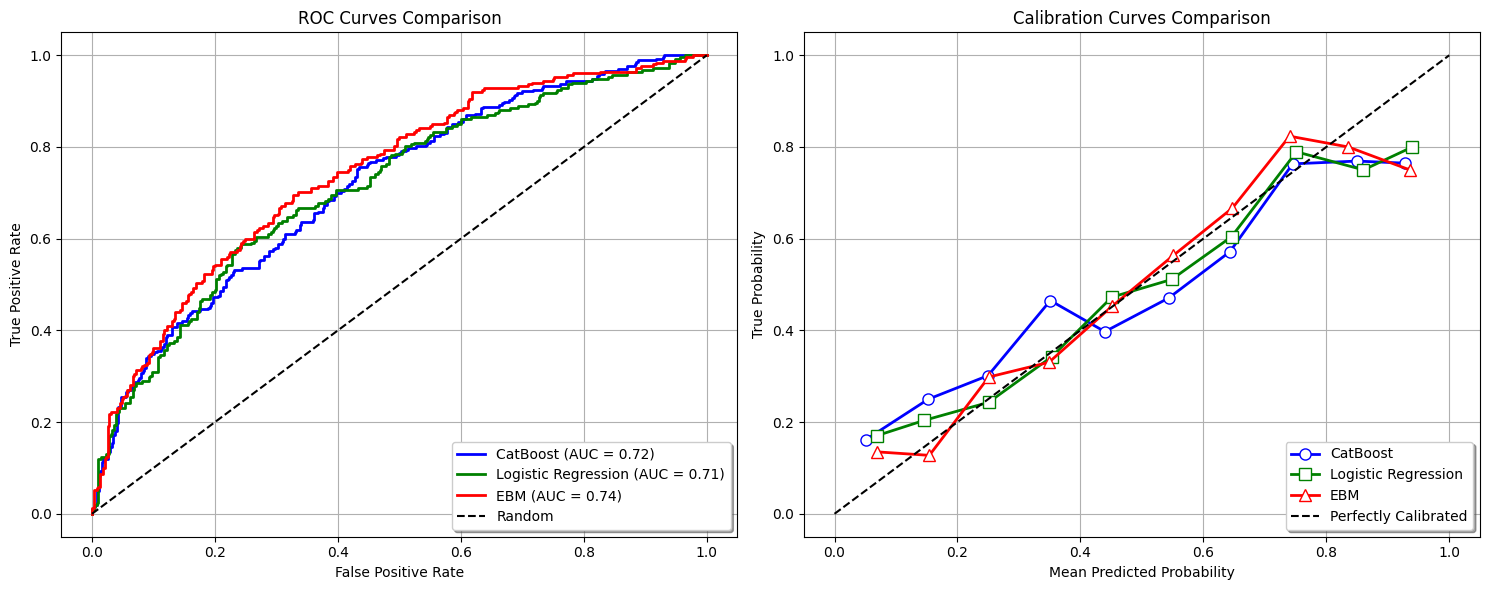

In [48]:
# Create subplots for ROC curves and calibration plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curves
ax1.plot(roc_auc_cb['fpr'], roc_auc_cb['tpr'], 
         label=f'CatBoost (AUC = {roc_auc_cb["auc_score"]:.2f})',
         color='blue', linestyle='-', linewidth=2)

ax1.plot(roc_auc_lr['fpr'], roc_auc_lr['tpr'],
         label=f'Logistic Regression (AUC = {roc_auc_lr["auc_score"]:.2f})',
         color='green', linestyle='-', linewidth=2)

ax1.plot(roc_auc_ebm['fpr'], roc_auc_ebm['tpr'],
         label=f'EBM (AUC = {roc_auc_ebm["auc_score"]:.2f})',
         color='red', linestyle='-', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison')
ax1.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
ax1.grid(True)

# Plot calibration curves
ax2.plot(calibration_cb['prob_pred'], calibration_cb['prob_true'],
         label='CatBoost', color='blue', marker='o', markersize=8,
         linewidth=2, markerfacecolor='white')

ax2.plot(calibration_lr['prob_pred'], calibration_lr['prob_true'],
         label='Logistic Regression', color='green', marker='s', markersize=8,
         linewidth=2, markerfacecolor='white')

ax2.plot(calibration_ebm['prob_pred'], calibration_ebm['prob_true'],
         label='EBM', color='red', marker='^', markersize=8,
         linewidth=2, markerfacecolor='white')

ax2.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('True Probability')
ax2.set_title('Calibration Curves Comparison')
ax2.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
ax2.grid(True)

plt.tight_layout()
plt.show()


# Next best action algorithm

In [8]:
# Get probabilities for both sets
train_probabilities = ebm.predict_proba(X_train)[:, 1]
test_probabilities = ebm.predict_proba(X_test)[:, 1]

def get_top_2_nba_with_gains(record):
    baseline_prob = ebm.predict_proba(record.to_frame().T)[:, 1][0]
    
    probability_gains = {}
    
    # Dynamic adjustment size based on current values
    adjustments = {
        'date between activate and start': {
            'condition': record['date between activate and start'] > 0,
            'change': -min(1, record['date between activate and start']),
            'description': 'Reduce activation to start time'
        },
        'employment_status_binary': {
            'condition': record['employment_status_binary'] == 0,
            'change': 1,
            'description': 'Gain employment'
        },
        'monthly_expenses_at_activation': {
            'condition': record['monthly_expenses_at_activation'] > -1,  # Since it's standardized
            'change': -min(1, record['monthly_expenses_at_activation']),
            'description': 'Reduce monthly expenses'
        },
        'payday_debt_balance_at_activation': {
            'condition': record['payday_debt_balance_at_activation'] > -1,
            'change': -min(1, record['payday_debt_balance_at_activation']),
            'description': 'Reduce payday debt'
        },
        'has_payday_debt_on_DCP_at_activation': {
            'condition': record['has_payday_debt_on_DCP_at_activation'] == 1,
            'change': -1,
            'description': 'Eliminate payday debt'
        }
    }
    
    for feature, adjustment in adjustments.items():
        if adjustment['condition']:
            record_adjusted = record.copy()
            record_adjusted[feature] += adjustment['change']
            
            adjusted_prob = ebm.predict_proba(record_adjusted.to_frame().T)[:, 1][0]
            gain = adjusted_prob - baseline_prob
            
            if gain > 0:  # Only include positive gains
                probability_gains[adjustment['description']] = gain
    
    # If no positive gains found, include all gains
    if not probability_gains:
        for feature, adjustment in adjustments.items():
            record_adjusted = record.copy()
            record_adjusted[feature] += adjustment['change']
            adjusted_prob = ebm.predict_proba(record_adjusted.to_frame().T)[:, 1][0]
            probability_gains[adjustment['description']] = adjusted_prob - baseline_prob
    
    sorted_gains = sorted(probability_gains.items(), key=lambda x: x[1], reverse=True)
    
    # Return top 2 or less if not enough actions available
    if len(sorted_gains) >= 2:
        return sorted_gains[0][0], sorted_gains[0][1], sorted_gains[1][0], sorted_gains[1][1]
    elif len(sorted_gains) == 1:
        return sorted_gains[0][0], sorted_gains[0][1], "No second action available", 0
    else:
        return "No action available", 0, "No second action available", 0

# Get NBA and gains for both sets
train_results = [get_top_2_nba_with_gains(record) for _, record in X_train.iterrows()]
test_results = [get_top_2_nba_with_gains(record) for _, record in X_test.iterrows()]

# Unzip the results
train_nba1, train_gain1, train_nba2, train_gain2 = zip(*train_results)
test_nba1, test_gain1, test_nba2, test_gain2 = zip(*test_results)

# Get IDs from original data
train_ids = data.iloc[X_train.index]['id']
test_ids = data.iloc[X_test.index]['id']

# Combine all results into a single DataFrame
output_df = pd.DataFrame({
    'id': np.concatenate([train_ids, test_ids]),
    'dcp_success_probability': np.concatenate([train_probabilities, test_probabilities]),
    'nba1': np.concatenate([train_nba1, test_nba1]),
    'nba1_probability_gain': np.concatenate([train_gain1, test_gain1]),
    'nba2': np.concatenate([train_nba2, test_nba2]),
    'nba2_probability_gain': np.concatenate([train_gain2, test_gain2])
})

# Save to CSV
output_df.to_csv('dcp_predictions_and_nba.csv', index=False)

# Print distribution of NBAs
print("\nDistribution of NBA1:")
print(output_df['nba1'].value_counts())
print("\nDistribution of NBA2:")
print(output_df['nba2'].value_counts())


Distribution of NBA1:
nba1
Reduce activation to start time    1535
Reduce monthly expenses            1001
Gain employment                     403
Reduce payday debt                  273
Name: count, dtype: int64

Distribution of NBA2:
nba2
No second action available         1434
Gain employment                     475
Eliminate payday debt               402
Reduce monthly expenses             336
Reduce activation to start time     313
Reduce payday debt                  252
Name: count, dtype: int64


# Payment simulation

In [4]:
# 1. Define payment columns
payment_columns = [f'pmtstatus{str(i).zfill(2)}' for i in range(1, 13)]

def preprocess_data(data, payment_num=None):
    """Preprocess data including payment status features"""
    df_processed = data.copy()
    
    # Convert payment statuses to one-hot encoded features
    if payment_num is not None:
        for i in range(1, payment_num + 1):
            col_name = f'pmtstatus{str(i).zfill(2)}'
            if col_name in df_processed.columns:
                # Create one-hot encoded columns for each payment status
                df_processed[f'payment_{i}_full'] = (df_processed[col_name] == 'full').astype(int)
                df_processed[f'payment_{i}_partial'] = (df_processed[col_name] == 'partial').astype(int)
                df_processed[f'payment_{i}_zero'] = (df_processed[col_name].isin(['zero', np.nan])).astype(int)
    
    # Drop unnecessary columns
    columns_to_drop = [
        'id', 'DCP_drop_status',
        'DCP_activation_date', 'DCP_start_date', 'DCP_drop_date',
        'DCP_start_date_year', 'DCP_start_date_month',
        'postal_prefix_at_activation',
        'duration_of_dcp', 'occupation_at_activation'
    ]
    columns_to_drop.extend([col for col in df_processed.columns if col.startswith('pmtstatus')])
    
    df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
    
    # Separate features and target
    X = df_processed.drop('target', axis=1)
    y = df_processed['target']
    
    # Handle missing values
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].fillna('Unknown')
        else:
            X[col] = X[col].fillna(X[col].median())
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, X.columns.tolist()

def get_top_2_nba_with_gains(record, current_model):
    """Get top 2 next best actions and their probability gains"""
    baseline_prob = current_model.predict_proba(record.to_frame().T)[:, 1][0]
    
    probability_gains = {}
    
    # Define possible adjustments
    adjustments = {
        'monthly_expenses_at_activation': {
            'condition': lambda x: x > 0,
            'change': lambda x: -0.1 * x,  # Reduce by 10%
            'description': 'Reduce monthly expenses by 10%'
        },
        'monthly_income_at_activation': {
            'condition': lambda x: True,
            'change': lambda x: 0.1 * x,  # Increase by 10%
            'description': 'Increase monthly income by 10%'
        },
        'debt_to_income_ratio': {
            'condition': lambda x: x > 0,
            'change': lambda x: -0.1 * x,  # Reduce by 10%
            'description': 'Reduce debt-to-income ratio by 10%'
        },
        'payday_debt_balance_at_activation': {
            'condition': lambda x: x > 0,
            'change': lambda x: -x,  # Eliminate payday debt
            'description': 'Eliminate payday debt'
        }
    }
    
    # Calculate gains for each possible adjustment
    for feature, adjustment in adjustments.items():
        if feature in record and adjustment['condition'](record[feature]):
            record_adjusted = record.copy()
            record_adjusted[feature] += adjustment['change'](record[feature])
            
            adjusted_prob = current_model.predict_proba(record_adjusted.to_frame().T)[:, 1][0]
            gain = adjusted_prob - baseline_prob
            
            if gain > 0:  # Only include positive gains
                probability_gains[adjustment['description']] = gain
    
    # Sort gains and get top 2
    sorted_gains = sorted(probability_gains.items(), key=lambda x: x[1], reverse=True)
    
    if len(sorted_gains) >= 2:
        return sorted_gains[0][0], sorted_gains[0][1], sorted_gains[1][0], sorted_gains[1][1]
    elif len(sorted_gains) == 1:
        return sorted_gains[0][0], sorted_gains[0][1], "No second action available", 0
    else:
        return "No action available", 0, "No second action available", 0

def simulate_payment_progression(data, payment_columns):
    results = []
    
    for payment_num in range(1, 13):
        print(f"\nProcessing payment {payment_num}...")
        
        # Create a new EBM model for each payment period
        current_model = ExplainableBoostingClassifier(random_state=42)
        
        # Process data with current payment history and train new model
        X_train, X_test, y_train, y_test, _ = preprocess_data(data, payment_num)
        current_model.fit(X_train, y_train)
        
        # Calculate probabilities using the new model
        X_combined = pd.concat([X_train, X_test])
        probabilities = current_model.predict_proba(X_combined)[:, 1]
        
        # Calculate payment statistics
        payment_stats = data[payment_columns[:payment_num]].apply(
            lambda x: pd.Series({
                'full_payments': (x == 'full').sum(),
                'partial_payments': (x == 'partial').sum(),
                'zero_payments': (x.isin(['zero', np.nan])).sum()
            }), axis=1)
        
        # Store results
        for idx, prob in enumerate(probabilities):
            # Get NBAs for current record
            nba1, gain1, nba2, gain2 = get_top_2_nba_with_gains(X_combined.iloc[idx], current_model)
            
            results.append({
                'id': data.iloc[X_combined.index[idx]]['id'],
                'payment_number': payment_num,
                'success_probability': prob,
                'full_payments': payment_stats['full_payments'].iloc[idx] if payment_num > 0 else 0,
                'partial_payments': payment_stats['partial_payments'].iloc[idx] if payment_num > 0 else 0,
                'zero_payments': payment_stats['zero_payments'].iloc[idx] if payment_num > 0 else 0,
                'payment_rate': payment_stats['full_payments'].iloc[idx] / payment_num if payment_num > 0 else 0,
                'nba1': nba1,
                'nba1_gain': gain1,
                'nba2': nba2,
                'nba2_gain': gain2
            })
    
    return pd.DataFrame(results)

# Run simulation
simulation_results = simulate_payment_progression(data, payment_columns)

# View results including NBAs
print("\nSuccess Probability and NBA Statistics by Payment Number:")
print(simulation_results.groupby('payment_number').agg({
    'success_probability': ['mean', 'std'],
    'payment_rate': 'mean',
    'nba1_gain': 'mean',
    'nba2_gain': 'mean'
}).round(3))

# Show most common NBAs for each payment period
print("\nMost Common Next Best Actions by Payment Period:")
for payment_num in range(1, 13):
    print(f"\nPayment {payment_num}:")
    period_data = simulation_results[simulation_results['payment_number'] == payment_num]
    print("Top NBA1:", period_data['nba1'].value_counts().head(1).to_dict())
    print("Top NBA2:", period_data['nba2'].value_counts().head(1).to_dict())


Processing payment 1...

Processing payment 2...

Processing payment 3...

Processing payment 4...

Processing payment 5...

Processing payment 6...

Processing payment 7...

Processing payment 8...

Processing payment 9...

Processing payment 10...

Processing payment 11...

Processing payment 12...

Success Probability and NBA Statistics by Payment Number:
               success_probability        payment_rate nba1_gain nba2_gain
                              mean    std         mean      mean      mean
payment_number                                                            
1                            0.389  0.241        0.658     0.018     0.002
2                            0.388  0.262        0.658     0.019     0.003
3                            0.388  0.261        0.643     0.015     0.002
4                            0.389  0.279        0.629     0.014     0.002
5                            0.389  0.283        0.617     0.012     0.002
6                            0.389  0.

In [6]:
# Save results
simulation_results.to_csv('payment_progression_predictions_with_nba.csv', index=False)

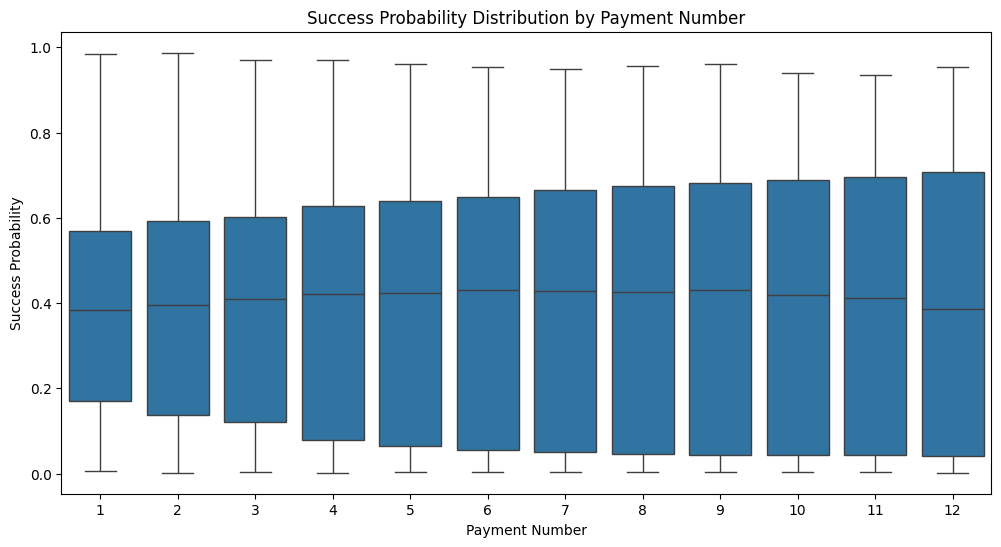


Most Common Next Best Actions:

Payment 1:
NBA1: nba1
Reduce monthly expenses by 10%        1041
Eliminate payday debt                  826
Reduce debt-to-income ratio by 10%     591
Name: count, dtype: int64
NBA2: nba2
No second action available            1422
Reduce monthly expenses by 10%         766
Reduce debt-to-income ratio by 10%     538
Name: count, dtype: int64

Payment 2:
NBA1: nba1
Reduce monthly expenses by 10%        1152
Eliminate payday debt                  679
Reduce debt-to-income ratio by 10%     663
Name: count, dtype: int64
NBA2: nba2
No second action available            1349
Reduce monthly expenses by 10%         802
Reduce debt-to-income ratio by 10%     559
Name: count, dtype: int64

Payment 3:
NBA1: nba1
Reduce monthly expenses by 10%        978
Eliminate payday debt                 940
Reduce debt-to-income ratio by 10%    687
Name: count, dtype: int64
NBA2: nba2
No second action available            1243
Reduce monthly expenses by 10%         863
Reduce d

/var/folders/pq/4qdgqs8x3_d8c4ysmcvszscr0000gn/T/ipykernel_7968/2828938563.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_dist = simulation_results.groupby(['payment_number', 'risk_category']).size().unstack()


<Figure size 1200x600 with 0 Axes>

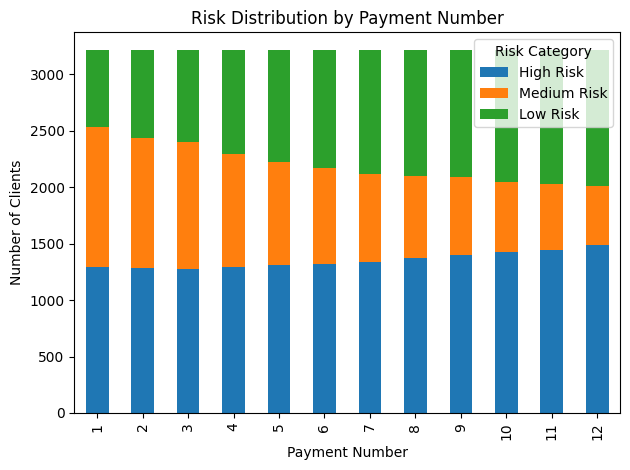


Analysis has been saved to 'payment_simulation_analysis.csv'

Critical Intervention Points (Higher score = Higher priority):
   payment_number  success_probability  nba1_gain  intervention_priority
1               2             0.387554   0.018589               0.047965
0               1             0.388752   0.018397               0.047324
2               3             0.388137   0.015259               0.039313
3               4             0.388580   0.013709               0.035280
5               6             0.389402   0.012893               0.033110


In [7]:
# 1. Basic Statistics and Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plot success probability distribution over payment periods
plt.figure(figsize=(12, 6))
sns.boxplot(data=simulation_results, x='payment_number', y='success_probability')
plt.title('Success Probability Distribution by Payment Number')
plt.xlabel('Payment Number')
plt.ylabel('Success Probability')
plt.show()

# 2. Analyze NBA recommendations
print("\nMost Common Next Best Actions:")
for payment_num in range(1, 13):
    payment_data = simulation_results[simulation_results['payment_number'] == payment_num]
    print(f"\nPayment {payment_num}:")
    print("NBA1:", payment_data['nba1'].value_counts().head(3))
    print("NBA2:", payment_data['nba2'].value_counts().head(3))

# 3. Average probability gains
print("\nAverage Probability Gains by Payment Period:")
avg_gains = simulation_results.groupby('payment_number').agg({
    'nba1_gain': 'mean',
    'nba2_gain': 'mean'
}).round(3)
print(avg_gains)

# 4. Identify High-Risk Periods
risk_by_period = simulation_results.groupby('payment_number')['success_probability'].agg(['mean', 'std']).round(3)
print("\nRisk Analysis by Payment Period:")
print(risk_by_period)

# 5. Create Risk Categories
simulation_results['risk_category'] = pd.cut(
    simulation_results['success_probability'],
    bins=[0, 0.3, 0.6, 1],
    labels=['High Risk', 'Medium Risk', 'Low Risk']
)

# Plot risk distribution
plt.figure(figsize=(12, 6))
risk_dist = simulation_results.groupby(['payment_number', 'risk_category']).size().unstack()
risk_dist.plot(kind='bar', stacked=True)
plt.title('Risk Distribution by Payment Number')
plt.xlabel('Payment Number')
plt.ylabel('Number of Clients')
plt.legend(title='Risk Category')
plt.tight_layout()
plt.show()

# 6. Save detailed analysis to CSV
analysis_results = simulation_results.groupby('payment_number').agg({
    'success_probability': ['mean', 'std', 'min', 'max'],
    'nba1_gain': ['mean', 'max'],
    'nba2_gain': ['mean', 'max']
}).round(3)

analysis_results.columns = ['_'.join(col).strip() for col in analysis_results.columns.values]
analysis_results.to_csv('payment_simulation_analysis.csv')

print("\nAnalysis has been saved to 'payment_simulation_analysis.csv'")

# 7. Identify Critical Intervention Points
critical_points = simulation_results.groupby('payment_number').agg({
    'success_probability': 'mean',
    'nba1_gain': 'mean'
}).reset_index()

critical_points['intervention_priority'] = critical_points['nba1_gain'] / critical_points['success_probability']
print("\nCritical Intervention Points (Higher score = Higher priority):")
print(critical_points.sort_values('intervention_priority', ascending=False).head())

# xgboost

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Load data
data = pd.read_csv('occupation_mapped.csv')

# Define the target variable
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

# Drop irrelevant columns
columns_to_drop = [
    'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04',
    'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08',
    'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
    'id', 'DCP_drop_status', 'DCP_activation_date', 'DCP_start_date',
    'DCP_drop_date', 'DCP_start_date_year', 'DCP_start_date_month',
    'postal_prefix_at_activation', 'asset_amount_owed_at_activation',
    'net_asset_value', 'duration_of_dcp', 'occupation_at_activation'
]
data = data.drop(columns=columns_to_drop, errors='ignore')



# Handle missing values
data.fillna(0, inplace=True)  # Replace missing values with 0 (you can use other strategies)

# Separate features and target
X = data.drop(columns=['target'])
y = data['target']
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    enable_categorical=True  # Enable support for categorical data
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.63
ROC-AUC Score: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       376
           1       0.58      0.46      0.51       267

    accuracy                           0.63       643
   macro avg       0.62      0.61      0.61       643
weighted avg       0.63      0.63      0.63       643



# AutoML

In [26]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Step 1: Initialize H2O
h2o.init()

# Step 2: Load data
data = pd.read_csv('occupation_mapped.csv')
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

# Drop unnecessary columns
columns_to_drop = [
    'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04',
    'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08',
    'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
    'id', 'DCP_drop_status', 'DCP_activation_date', 'DCP_start_date',
    'DCP_drop_date', 'DCP_start_date_year', 'DCP_start_date_month',
    'postal_prefix_at_activation', 'asset_amount_owed_at_activation',
    'net_asset_value', 'duration_of_dcp', 'occupation_at_activation'
]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Step 3: Convert to H2OFrame
h2o_data = h2o.H2OFrame(data)

# Step 4: Convert target to categorical
h2o_data['target'] = h2o_data['target'].asfactor()

# Step 5: Split data
train, test = h2o_data.split_frame(ratios=[0.8], seed=42)

# Step 6: Run AutoML
aml = H2OAutoML(
    max_runtime_secs=300,  # Allow 5 minutes
    max_models=20,         # Train up to 20 models
    seed=42,
    balance_classes=True,  # Handle class imbalance
    sort_metric="AUC"      # Optimize for AUC
)
aml.train(x=[col for col in h2o_data.columns if col != 'target'], y='target', training_frame=train)

# Step 7: View leaderboard
print(aml.leaderboard)

# Step 8: Make predictions
predictions = aml.leader.predict(test)
print(predictions.head())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,14 mins 31 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_yuchenzhang_z41q8e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.75 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:45:04.268: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse       mse
GLM_1_AutoML_10_20241128_204504               0.70056    0.603534  0.579969                0.359596  0.457048  0.208893
DRF_1_AutoML_10_20241128_204504               0.693092   0.625244  0.571512                0.365593  0.46458   0.215834
GBM_grid_1_AutoML_10_20241128_204504_model_3  0.672869   0.639431  0.546782                0.397475  0.471147  0.221979
GBM_grid_1_AutoML_10_20241128_204504_model_4  0.667228   0.653492  0.54203                 0.419508  0.475144  0.225762
XRT_1_AutoML_10_20241128_204504               0.665147   0.633477  0.540743                0.403346  0.470546  0.221413
GBM_3_AutoML_10_20241128_20